In [78]:
import time
import random
import keras
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras.src.layers import Lambda, Reshape, Conv1D, BatchNormalization, LeakyReLU, Dropout, Dense, Input, SpatialDropout1D, MaxPooling1D, GlobalMaxPooling1D, concatenate

from utils import zoom, normlize_range, get_CG

In [79]:
random.seed(123)

In [80]:
class Config:
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.feat_d = 231
        self.filters = 16
        self.data_dir = '../data/SHREC/'
C = Config()

In [81]:
def poses_diff(x):
    H, W = x.get_shape()[1], x.get_shape()[2]
    x = tf.subtract(x[:, 1:, ...], x[:, :-1, ...])
    x = tf.image.resize(x, size=[H, W])

    return x

def pose_motion(P, frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l, -1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:, ::2, ...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l / 2), -1))(P_diff_fast)

    return P_diff_slow, P_diff_fast
    
def c1D(x, filters, kernel):
    x = Conv1D(filters, kernel_size=kernel, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    return x

def block(x, filters):
    x = c1D(x, filters, 3)
    x = c1D(x, filters, 3)

    return x
    
def d1D(x,filters):
    x = Dense(filters, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    return x

def build_FM(frame_l=32, joint_n=22, joint_d=2, feat_d=231, filters=16):
    M = Input(shape=(frame_l, feat_d))
    P = Input(shape=(frame_l, joint_n, joint_d))
    
    diff_slow, diff_fast = pose_motion(P, frame_l)
    
    x = c1D(M ,filters * 2, 1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x, filters, 3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x, filters, 1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow, filters * 2, 1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow, filters, 3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow, filters,1)
    x_d_slow = MaxPooling1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast, filters * 2, 1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast, filters, 3)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast, filters,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x, x_d_slow, x_d_fast])
    x = block(x, filters * 2)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x, filters * 4)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x, filters * 8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M, P], outputs=x)

In [82]:
def build_DD_Net(frame_l=32, joint_n=22, joint_d=3, feat_d=231, clc_num=14, filters=16):
    M = Input(name='M', shape=(frame_l, feat_d))
    P = Input(name='P', shape=(frame_l, joint_n, joint_d))
    
    FM = build_FM(frame_l, joint_n, joint_d, feat_d, filters)
    
    x = FM([M, P])

    x = GlobalMaxPooling1D()(x)
    
    x = d1D(x, 128)
    x = Dropout(0.5)(x)
    x = d1D(x, 128)
    x = Dropout(0.3)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    model = Model(inputs=[M, P], outputs=x)
    
    return model

In [83]:
DD_Net = build_DD_Net(C.frame_l, C.joint_n, C.joint_d, C.feat_d, C.clc_coarse, C.filters)

In [84]:
DD_Net.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 M (InputLayer)              [(None, 32, 231)]            0         []                            
                                                                                                  
 P (InputLayer)              [(None, 32, 22, 3)]          0         []                            
                                                                                                  
 model_8 (Functional)        (None, 4, 128)               119392    ['M[0][0]',                   
                                                                     'P[0][0]']                   
                                                                                                  
 global_max_pooling1d_4 (Gl  (None, 128)                  0         ['model_8[0][0]']       

## load data

In [85]:
Train = pickle.load(open(C.data_dir + "train.pkl", "rb"))
Test = pickle.load(open(C.data_dir + "test.pkl", "rb"))

In [86]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1, 22, 3])
    p = zoom(p, target_l=C.frame_l, joints_num=C.joint_n, joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i] - 1] = 1

    M = get_CG(p, C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

100%|██████████| 1960/1960 [00:05<00:00, 352.57it/s]


In [87]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1, 22, 3])
    p = zoom(p, target_l=C.frame_l, joints_num=C.joint_n, joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i] - 1] = 1

    M = get_CG(p, C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|██████████| 840/840 [00:02<00:00, 371.73it/s]


In [89]:
lr = 1e-5
DD_Net.compile(loss="categorical_crossentropy",
               optimizer=keras.optimizers.legacy.Adam(lr),
               metrics=['accuracy'])

In [90]:
def train(DD_Net, Train, C, X_test_0, X_test_1, Y_test, epochs=100):
    callbacks = []
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                     factor=0.5,
                                                     patience=5,
                                                     cooldown=5,
                                                     min_lr=5e-6)
    callbacks.append(lr_scheduler)
    
    history = DD_Net.fit([X_0,X_1],Y,
                        batch_size=len(Y),
                        epochs=400,
                        verbose=True,
                        shuffle=True,
                        callbacks=callbacks,
                        validation_data=([X_test_0,X_test_1],Y_test)
                        )
    
    return DD_Net, history

In [91]:
DD_Net, history = train(DD_Net, Train, C, X_test_0, X_test_1, Y_test, epochs=100)

Epoch 1/400


2023-08-02 23:58:29.011612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 3.1479 - accuracy: 0.0724

2023-08-02 23:58:32.230056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step - loss: 3.1479 - accuracy: 0.0724 - val_loss: 2.6390 - val_accuracy: 0.0821 - lr: 1.0000e-05
Epoch 2/400
1/1 [==============================] - 0s 407ms/step - loss: 3.1184 - accuracy: 0.0684 - val_loss: 2.6390 - val_accuracy: 0.0798 - lr: 1.0000e-05
Epoch 3/400
1/1 [==============================] - 0s 278ms/step - loss: 3.1178 - accuracy: 0.0689 - val_loss: 2.6389 - val_accuracy: 0.0738 - lr: 1.0000e-05
Epoch 4/400
1/1 [==============================] - 0s 300ms/step - loss: 3.1270 - accuracy: 0.0658 - val_loss: 2.6389 - val_accuracy: 0.0726 - lr: 1.0000e-05
Epoch 5/400
1/1 [==============================] - 1s 538ms/step - loss: 3.1294 - accuracy: 0.0673 - val_loss: 2.6390 - val_accuracy: 0.0726 - lr: 1.0000e-05
Epoch 6/400
1/1 [==============================] - 0s 318ms/step - loss: 3.1058 - accuracy: 0.0821 - val_loss: 2.6390 - val_accuracy: 0.0726 - lr: 1.0000e-05
Epoch 7/400
1/1 [==============================] - 0s 299ms/step - 

In [92]:
DD_Net.save_weights('../models/ddnet.h5')

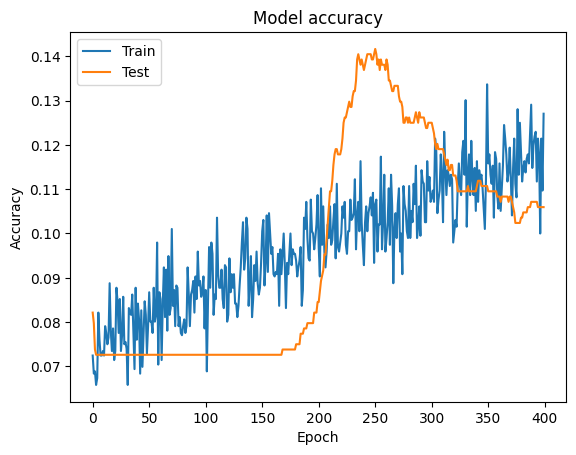

In [96]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Calculate time (excute it twice, the first time initialize takes extra times)

In [94]:
start_time = time.time()
y = DD_Net.predict([X_0, X_1])
time.time() - start_time

2023-08-03 00:00:01.726339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 3s 24ms/step


3.697118043899536

# Plot confusion matrix

27/27 [==============================] - 0s 14ms/step


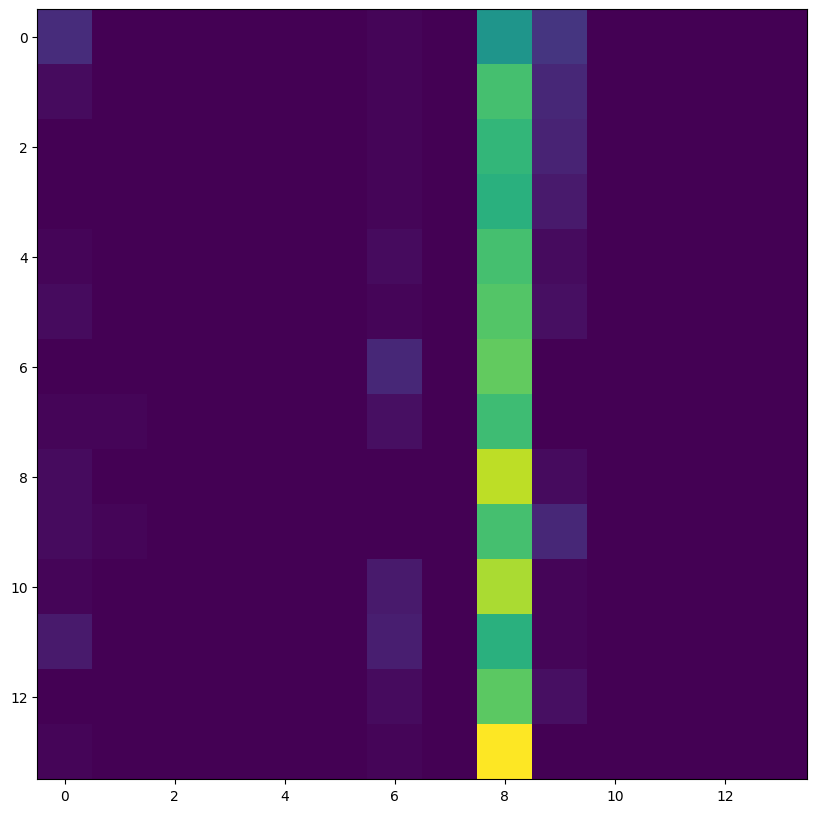

In [95]:
Y_pred = DD_Net.predict([X_test_0, X_test_1])
cnf_matrix = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
plt.figure(figsize=(10, 10))
plt.imshow(cnf_matrix)
plt.show()